In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.parse

In [2]:
# code for reading all HTLM files in the directory

In [3]:
import os, sys

wp_path = "/Users/ginevralarroux/Desktop/EPFL courses/Applied data analysis/ADA project/data/wpcd/wp/" # to adapt
directories = os.listdir(wp_path)

html_list = []
for dir in directories:
    local_path = wp_path + dir
    local_dir = os.listdir(local_path)
    for link in local_dir:
        if link[-3:]=='htm':
            html_list.append(dir+'/'+link)
html_list[:10]

['r/Royal_Marines.htm',
 'r/Recycling.htm',
 'r/Retreat_of_glaciers_since_1850.htm',
 'r/Remember_Girls_Like_Rajpura.htm',
 'r/Rutherfordium.htm',
 'r/Rule_of_St_Benedict.htm',
 'r/Red_dwarf.htm',
 'r/Romeo_and_Juliet.htm',
 'r/Rudyard_Kipling.htm',
 'r/Race.htm']

The aim of this specific game strategy analysis is to test whether Wikispeedia players have clikability preferences on the basis of the hyperlinks' positioning throughout the article text. 
In particular:
1. we wil find the ordinal number of paragraph each hyperlink shows up in and divide it by the total number of paragraphs of the article, to determine its positioning; 
2. we will find if each clicked hyperlink shows up in images' captions in the article.
We will then investigate if there is a correlation between the clickability of the hyperlinks and their location, using the most appropriate statistical tests. 

It is therefore essential to extract from the data the frequency of clicks for each hyperlink.

In [4]:
# code for extracting the hyperlinks click frequency  

In [5]:
folder='/Users/ginevralarroux/Desktop/EPFL courses/Applied data analysis/ADA project/data/wikispeedia_paths-and-graph/'

paths_finished='paths_finished.tsv'
articles='articles.tsv'

paths_finished=pd.read_csv(folder+paths_finished, sep='\t', skiprows=15, header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
articles=pd.read_csv(folder+articles, sep='\t', skiprows=12, header=None, names=['article'])

This dataframe contains the paths chosen by the players who could reach the target article.

In [6]:
paths_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


This dataframe lists all the clickable articles.

In [12]:
def filter_article_name(article_list):
    new_article_list=[]
    for article in article_list:
        article = urllib.parse.unquote(article)
        article = article.lower()
        article = article.replace('_', ' ')
        article = article.strip()
        new_article_list.append(article)
    return new_article_list

articles.article=filter_article_name(articles.article)
articles.head(100)

,article
0,áedán mac gabráin
1,åland
2,édouard manet
3,éire
4,óengus i of the picts
...,...
95,able archer 83
96,abraham goldfaden
97,abraham lincoln
98,absinthe


In [14]:
# this is the articles list in the lists of paths
    
clicked_articles=[]
for x in paths_finished['path']: # hypothesize also in paths_unfinished
    path=(x.split(';'))
    clicked_articles.append(path)

clicked_articles_filtered=[]
for path in clicked_articles:
    path_filtered=filter_article_name(path)
    if '14th century' in path:
        path.remove('14th century') #it does not work
    clicked_articles_filtered.append(path_filtered)

clicked_articles_filtered[:10]

[['14th century',
  '15th century',
  '16th century',
  'pacific ocean',
  'atlantic ocean',
  'accra',
  'africa',
  'atlantic slave trade',
  'african slave trade'],
 ['14th century',
  'europe',
  'africa',
  'atlantic slave trade',
  'african slave trade'],
 ['14th century',
  'niger',
  'nigeria',
  'british empire',
  'slavery',
  'africa',
  'atlantic slave trade',
  'african slave trade'],
 ['14th century', 'renaissance', 'ancient greece', 'greece'],
 ['14th century',
  'italy',
  'roman catholic church',
  'hiv',
  'ronald reagan',
  'president of the united states',
  'john f. kennedy'],
 ['14th century',
  'europe',
  'north america',
  'united states',
  'president of the united states',
  'john f. kennedy'],
 ['14th century', 'china', 'gunpowder', 'fire'],
 ['14th century', 'time', 'isaac newton', 'light', 'color', 'rainbow'],
 ['14th century', 'time', 'light', 'rainbow'],
 ['14th century',
  '15th century',
  'plato',
  'nature',
  'ultraviolet',
  'color',
  'rainbow']]

In [15]:
# this is the dataframe containing the hyperlinks and their clicktrhough frequency

links_name=[]
links_freq=[]

i=0

for article in articles['article']:
    count=0
    links_name.append(article)
    for i in range(len(clicked_articles_filtered)):
        if article in clicked_articles_filtered[i]:
            count+=1 
    links_freq.append(count)

links_name=pd.Series(links_name)
links_freq=pd.Series(links_freq)
links_freq_df=pd.concat([links_name, links_freq], axis=1, names=['link', '#_clicks'])
links_freq_df.columns=['link', '#_clicks']
links_freq_df.loc[links_freq_df['#_clicks']!=0].head()

,link,#_clicks
1,åland,2
2,édouard manet,2
3,éire,3
5,€2 commemorative coins,1
6,10th century,109


In [16]:
# code for extracting the positioning of the hyperlinks in the article text

In [17]:
from bs4 import BeautifulSoup

In [18]:
# read all the files

soups=[]
failed_html_list = []
for html in html_list[:]:
    f=open(wp_path+html, 'r')
    try:
        soup = BeautifulSoup(f, 'lxml')
        soups.append(soup)
    except Exception:
        failed_html_list.append(html)

In [20]:
failed_html_list[:5]

['u/Ukraine_A.htm',
 'g/G4_Classic_Response.htm',
 'g/Gambia.htm',
 'g/Ghana_Cv_Tema.htm',
 't/Tbilisi.htm']

In [21]:
# example with 1 file

In [62]:
URL = '/Users/ginevralarroux/Desktop/EPFL courses/Applied data analysis/ADA project/data/wpcd/wp/a/A_cappella.htm'

f=open(URL, 'r')
soup1 = BeautifulSoup(f, 'lxml')

In [147]:
# HTML tag for hyperlinks is <a href= >
# this is the dataframe of the hyperlinks contained in an article, with the number of paragraph they show up in 
# and its relative postion in the article

def find_links(soup):
    paragraphs = soup.find_all('p')
    links=[]
    i=0
    for p in paragraphs:
        i+=1
        all_links=p.find_all('a')
        for link in all_links:
            if 'href' in link.attrs:
                link_title=link.text
                link_paragraph=i
                links.append([link_title, link_paragraph])
                
    link_positioning_df=pd.DataFrame(links, columns=['link', '#_paragraph']).drop_duplicates()
    link_positioning_df['positioning']=round(link_positioning_df['#_paragraph']/len(paragraphs), 2)
    link_positioning_df['link']=filter_article_name(link_positioning_df['link'])
    return link_positioning_df

link_positioning_df=find_links(soup1)
link_positioning_df

,link,#_paragraph,positioning
0,music,1,0.04
1,instrumental,1,0.04
2,renaissance,1,0.04
3,gregorian chant,3,0.12
4,renaissance,3,0.12
5,amish,5,0.21
6,eastern orthodox,5,0.21
7,jewish,8,0.33
8,beatles,18,0.75
9,hindi,21,0.88


In [148]:
# function for all html files

link_positioning_dfs=[]
for soup in soups:
    link_positioning_dfs.append(find_links(soup))

link_positioning_dfs[:5]

[                              link  #_paragraph  positioning
 0                       royal navy            1         0.01
 1                   united kingdom            1         0.01
 2                         cold war           18         0.19
 3                     sierra leone           20         0.21
 4                         dartmoor           24         0.25
 5                     world war ii           29         0.30
 6                         plymouth           34         0.35
 7                         scotland           34         0.35
 8                        gibraltar           43         0.44
 9                             cuba           44         0.45
 10               george washington           44         0.45
 11                      royal navy           45         0.46
 13                      portsmouth           46         0.47
 14                        plymouth           46         0.47
 15      american revolutionary war           46         0.47
 16     

In [ ]:
# analysis of 2 files 

In [64]:
URL = '/Users/ginevralarroux/Desktop/EPFL courses/Applied data analysis/ADA project/data/wpcd/wp/m/Music.htm'

f_music=open(URL, 'r')
soup_music = BeautifulSoup(f_music, 'lxml')

link_positioning_df_m=find_links(soup_music)
link_positioning_df_m

,link,#_paragraph,positioning
0,art,1,0.01
1,sounds,1,0.01
2,artistic,1,0.01
3,aesthetic,1,0.01
4,communicative,1,0.01
5,painting,2,0.03
6,sound,4,0.06
7,johann wolfgang goethe,8,0.11
8,culture,10,0.14
9,india,10,0.14


In [65]:
# merging the 2 dataframes

merged=link_positioning_df.merge(link_positioning_df_m, how='outer', left_on='link', right_on='link', )
columns_to_drop=['#_paragraph_x', '#_paragraph_y']
m=merged.drop(labels=columns_to_drop, axis=1)
m

,link,positioning_x,positioning_y
0,music,0.04,NaN
1,instrumental,0.04,NaN
2,renaissance,0.04,NaN
3,renaissance,0.12,NaN
4,gregorian chant,0.12,NaN
5,amish,0.21,NaN
6,eastern orthodox,0.21,NaN
7,jewish,0.33,NaN
8,beatles,0.75,NaN
9,hindi,0.88,NaN


In [150]:
# function for all html files

for df in link_positioning_dfs:
    try:
        df.drop(labels='#_paragraph', axis=1, inplace=True)  #need to fix this
    except:
        pass    


link_positioning_dfs=link_positioning_dfs[:100]
from functools import reduce
links_pos_dfs_merged = reduce(lambda  left,right: pd.merge(left,right,on=['link'],how='outer'), link_positioning_dfs)
links_pos_dfs_merged.head() #need to fix this 

/var/folders/98/5x9_sw_93w565h0fcpcfq0f40000gn/T/ipykernel_24201/1644410041.py:12: FutureWarning: Passing 'suffixes' which cause duplicate columns {'positioning_x'} in the result is deprecated and will raise a MergeError in a future version.
  links_pos_dfs_merged = reduce(lambda  left,right: pd.merge(left,right,on=['link'],how='outer'), link_positioning_dfs)
/var/folders/98/5x9_sw_93w565h0fcpcfq0f40000gn/T/ipykernel_24201/1644410041.py:12: FutureWarning: Passing 'suffixes' which cause duplicate columns {'positioning_x'} in the result is deprecated and will raise a MergeError in a future version.
  links_pos_dfs_merged = reduce(lambda  left,right: pd.merge(left,right,on=['link'],how='outer'), link_positioning_dfs)
/var/folders/98/5x9_sw_93w565h0fcpcfq0f40000gn/T/ipykernel_24201/1644410041.py:12: FutureWarning: Passing 'suffixes' which cause duplicate columns {'positioning_x'} in the result is deprecated and will raise a MergeError in a future version.
  links_pos_dfs_merged = reduce(la

,link,positioning_x,positioning_y,positioning_x,positioning_y,positioning_x,positioning_y,positioning_x,positioning_y,positioning_x,...,positioning_x,positioning_y,positioning_x,positioning_y,positioning_x,positioning_y,positioning_x,positioning_y,positioning_x,positioning_y
0,royal navy,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,royal navy,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,royal navy,0.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,royal navy,0.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,royal navy,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
# function that determines the msot frequent position of each hyperlink in the set of all articles

def find_positioning(array):
    bin_labels=['top', 'center', 'bottom']
    bins=[0, 0.33, 0.66, 1]
    cut_positioning=pd.cut(array, bins, labels=bin_labels)
    positioning_frequency=pd.value_counts(cut_positioning)
    most=positioning_frequency.apply('max')
    if len(positioning_frequency[positioning_frequency==most])>1:
        return np.random.choice(positioning_frequency[positioning_frequency==most].index.values.astype(str)) #account for same frequency
    else:
        return positioning_frequency[positioning_frequency==most].index.values.astype(str).item()


In [82]:
most_freq_positioning=m.groupby(by=m['link']).apply(lambda x: find_positioning(np.array(x.values).flatten()))
most_freq_positioning_df=pd.DataFrame(most_freq_positioning, columns=['most_freq_positioning'])
most_freq_positioning_df=most_freq_positioning_df.reset_index()
most_freq_positioning_df

,link,most_freq_positioning
0,aesthetic,top
1,amish,top
2,anthropology,bottom
3,art,top
4,artistic,top
5,beatles,bottom
6,beethoven,top
7,bluegrass,top
8,communicative,top
9,culture,top


In [97]:
# function for all html files

most_freq_positioning=links_pos_dfs_merged.set_index("link").groupby("link").apply(lambda x: find_positioning(x.values.flatten()))
most_freq_positioning_df=pd.DataFrame(most_freq_positioning, columns=['most_freq_positioning'])
most_freq_positioning_df

,most_freq_positioning
link,
15th marine expeditionary unit,bottom
abbot,top
afghanistan,center
africa,top
african slave trade,top
...,...
william shakespeare,top
wines,top
work in india,bottom


In [78]:
links_freq_pos=links_freq_df.merge(most_freq_positioning_df, left_on='link', right_on='link')
links_freq_pos

,link,#_clicks,most_freq_positioning
0,amish,19,top
1,anthropology,142,bottom
2,art,589,top
3,culture,583,top
4,folk music,155,top
5,gregorian chant,34,top
6,hindi,61,bottom
7,india,1216,top
8,jazz,281,top
9,johann wolfgang goethe,16,top


In [86]:
links_freq_pos=links_freq_df.merge(most_freq_positioning_df, left_on='link', right_on='link')
links_freq_pos

,link,#_clicks,most_freq_positioning
0,15th marine expeditionary unit,6,bottom
1,abbot,24,top
2,afghanistan,158,bottom
3,africa,2738,top
4,african slave trade,31,top
...,...,...,...
158,waste management,27,top
159,westminster abbey,79,bottom
160,william shakespeare,304,top
161,world war ii,2267,top


In [79]:
links_freq_pos_grouped=links_freq_pos['#_clicks'].groupby(links_freq_pos['most_freq_positioning']).sum()
links_freq_pos_grouped_df=pd.DataFrame(links_freq_pos_grouped)
links_freq_pos_grouped_df

,#_clicks
most_freq_positioning,
bottom,2575
center,180
top,4551


In [87]:
links_freq_pos_grouped=links_freq_pos['#_clicks'].groupby(links_freq_pos['most_freq_positioning']).sum()
links_freq_pos_grouped_df=pd.DataFrame(links_freq_pos_grouped)
links_freq_pos_grouped_df

,#_clicks
most_freq_positioning,
bottom,17772
center,13903
top,29571


Text(0.5, 0, 'Positioning')

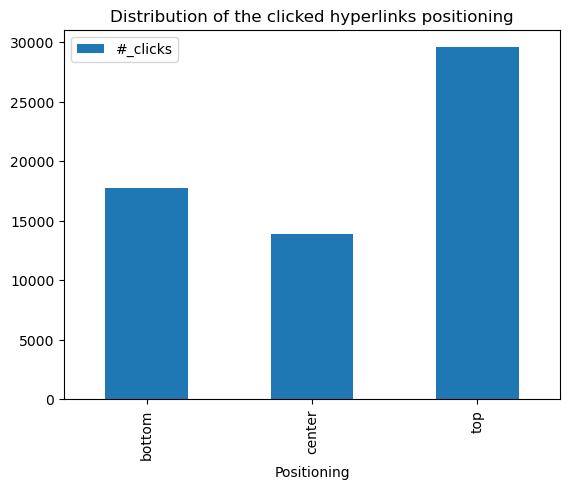

In [88]:
# visualization of the Distribution of the clicked hyperlinks' positioning

links_freq_pos.sort_values(by='#_clicks', ascending=False, inplace=True)
#links_freq_pos=links_freq_pos[:1000] # may be interesting to 1000 most clicked articles 
#links_freq_pos=links_freq_pos[:-1000] # 1000 least clicked articles 

ax = links_freq_pos_grouped_df.plot.bar()
ax.set_title('Distribution of the clicked hyperlinks positioning')
ax.set_xlabel('Positioning')

In [ ]:
# plot distribution of hyperlinks in the text

In [151]:
def find_positioning_dis(array):
    bin_labels=['top', 'center', 'bottom']
    bins=[0, 0.33, 0.66, 1]
    cut_positioning=pd.cut(array, bins, labels=bin_labels)
    positioning_frequency=pd.value_counts(cut_positioning)
    return positioning_frequency

In [155]:
positioning_freq=links_pos_dfs_merged.set_index("link").groupby("link").apply(lambda x: find_positioning_dis(x.values.flatten()))
positioning_freq_df=pd.DataFrame(positioning_freq, columns=['positioning_freq'])
positioning_freq_df.reset_index(level=1, inplace=True)
positioning_freq_df.rename(columns={'level_1':'positioning'}, inplace=True)
positioning_freq_df.head(20)

,positioning,positioning_freq
link,,
,bottom,22
,top,11
,center,11
"""ruffian dick""",top,1
"""ruffian dick""",center,0
"""ruffian dick""",bottom,0
(france),bottom,1
(france),top,0
(france),center,0


In [156]:
positioning_freq_df_grouped=positioning_freq_df.groupby('positioning').sum()
positioning_freq_df_grouped
#positioning_freq_df_grouped.loc[positioning_freq_df_grouped['positioning_freq']>1]

,positioning_freq
positioning,
top,10252
center,3449
bottom,4472


Text(0.5, 0, 'Positioning')

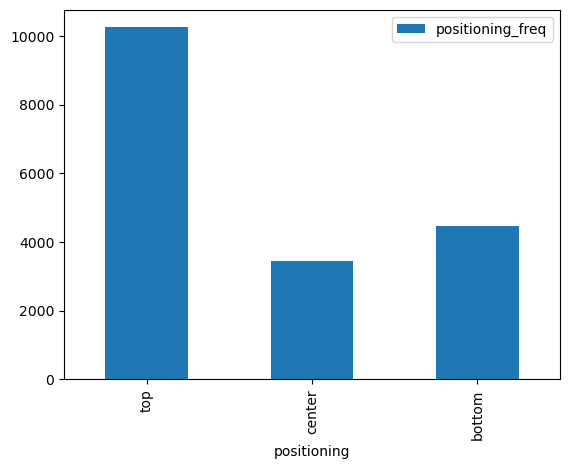

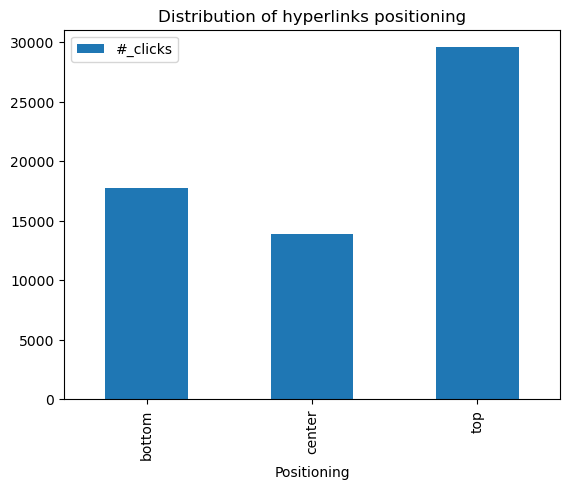

In [158]:
ax = positioning_freq_df_grouped.plot.bar()
ax = links_freq_pos_grouped_df.plot.bar()
ax.set_title('Distribution of hyperlinks positioning')
ax.set_xlabel('Positioning')

In [ ]:
# code for finding hyperlinks in images' caption

In [ ]:
# example with 1 file

In [ ]:
URL = '/Users/ginevralarroux/Desktop/EPFL courses/Applied data analysis/ADA project/data/wpcd/wp/a/Aachen.htm'
f2=open(URL, 'r')
soup2 = BeautifulSoup(f2, 'lxml')

In [ ]:
# in an HTML file the images can be either find under tables or div tags 

In [ ]:
# images of hyperlinks in tables' captions

def find_link_in_table(soup):
    
    tables = soup.find_all('table')

    links=[]
    for table in tables:
        if table.find('img'):
            all_links=table.find_all('a')
            for link in all_links:
                if 'class' not in link.attrs:
                    link_title=link.text
                    links.append(link_title)

    if links:
        links_in_table_df=pd.DataFrame(links).drop_duplicates()
        links_in_table_df.columns=['link']
        links_in_table_df=links_in_table_df.apply(filter_article_name) 
    else: 
        return None
    return links_in_table_df

find_link_in_table(soup2)

In [ ]:
links_in_tables=[]
for soup in soups:
    links_in_tables.append(find_link_in_table(soup))

links_in_tables=pd.concat(links_in_tables, axis=0)
links_in_tables

In [ ]:
# images under div tags
def find_links_in_img(soup):
    div = soup.find_all('div')

    links=[]

    for d in div:
        if (d.find('a', class_="internal")):
            if (d.find('img', class_='thumbimage')):
                caption=d.find('div', class_="thumbcaption")
                if (caption.find('a')):
                    all_links=caption.find_all('a')
                    for link in all_links:
                        if 'class' not in link.attrs:
                            link_title=link.text
                            links.append(link_title)
    if links:
        links_in_image_df=pd.DataFrame(links).drop_duplicates()
        links_in_image_df.columns=['link']
        links_in_image_df=links_in_image_df.apply(filter_article_name) 
    else: 
        return None
        links_in_image_df=pd.DataFrame()
    return links_in_image_df


find_links_in_img(soup2)

In [ ]:
find_links_in_img(soups[0])

In [ ]:
links_in_images=[]
for soup in soups:
    #if get_hrefs_pics(soup):
    links_in_images.append(find_links_in_img(soup))

links_in_images=pd.concat(links_in_images, axis=0)
links_in_images

In [ ]:
len(soups)

In [ ]:
# function for all html files

def find_links_in_div(soups):
    dfs=[]
    for soup in soups:
        div = soup.find_all('div')
        links=[]
        for d in div:
            if (d.find('a', class_="internal")):
                print('yes')
                if d.find('div', class_="thumbcaption"):
                    print('yes, yes')
                    caption=d.find('div', class_="thumbcaption")
                    if (caption.find('a')):
                        all_links=caption.find_all('a')
                        print(all_links)
                    
                        if len(all_links)>1:
                            print(len(all_links))
                            for link in all_links:
                                if 'class' not in link.attrs:
                                
                                    link_title=link.text
                                    links.append(link_title)
                            
        if link:
            links_in_image_df=pd.DataFrame(links).drop_duplicates()
            links_in_image_df.columns=['link_in_image']
            links_in_image_df=links_in_image_df.apply(filter_article_name)     
    return dfs

links_in_image_dfs=find_links_in_div(soups)
links_in_image_dfs

In [ ]:
# code for frequency of clicks for link in images 

In [ ]:
# example with 2 files

In [ ]:
links_in_image_dfs=[links_in_image_df, links_in_table_df] #not needed for dataframes of all articles
link_in_image_concatenated=pd.concat(links_in_image_dfs, axis=0).reset_index(drop=True).drop_duplicates()
link_in_image_concatenated

In [ ]:
flag=[]
links_freq_img=links_freq_df.copy()

for link in links_freq_df['link']:
    if link in list(link_in_image_concatenated['link']):
        flag.append(1)
    else:
        flag.append(0)
    
links_freq_img['in_image']=flag
links_freq_img[links_freq_img['in_image']==1]

In [ ]:
links_freq_img_grouped_df=pd.DataFrame(links_freq_img['#_clicks'].groupby(links_freq_img['in_image']).sum())
links_freq_img_grouped_df

In [ ]:
# visualization of img  

ax = links_freq_img_grouped_df.plot.bar()
ax.set_title('Distribution of the clicked hyperlinks in images captions')
ax.set_xlabel('In image caption')

In [ ]:
# assumptions: 
# we don't know for the hyperlinks that show up both in the article text and in the image caption, 
# which the player actually clicked 
# for the hyperlinks which show up multiple times in the article ...